In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import os.path as path
import numpy as np
import torch
from matplotlib.patches import Rectangle
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import cv2
import random
import math
import seaborn as sns
sns.set(font_scale=1.5)
from pprint import pprint
from IPython.display import HTML # to show the animation in Jupyter
import pandas as pd
from collections import Counter
from scipy.ndimage import convolve1d

plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
sns.set_style("whitegrid", {'axes.grid' : False})
plt.rcParams["figure.autolayout"] = True
import sys
sys.path.append('../')
from src import utils, RWSampler, Inference

### Vanilla

In [37]:
RGB_test_cost_vanilla = pd.read_csv('/data2/hkaman/Imbalance/EXPs/EXP_000_001_05_RGB_vanilla/000_001_05_RGB_vanilla_train.csv',  index_col=0) 
ytrue_vanilla         = RGB_test_cost_vanilla['ytrue']

### Cost Sensitive Weight Resampler 

In [38]:
RGB_test_cost_sensitive        = pd.read_csv('/data2/hkaman/Imbalance/EXPs/EXP_001_RGB_BHO/001_RGB_BHO_train.csv',  index_col=0) 
ytrue_cost_sensitive_effective = RGB_test_cost_sensitive['ytrue']

In [40]:
RGB_test_cost_sensitive

,ytrue,ypred_w1,ypred_w2,ypred_w3,ypred_w4,ypred_w5,ypred_w6,ypred_w7,ypred_w8,ypred_w9,ypred_w10,ypred_w11,ypred_w12,ypred_w13,ypred_w14,ypred_w15
0,11.613479,10.140902,10.274446,14.006334,14.036917,14.035721,14.050335,14.062630,14.060770,14.051762,14.043617,14.033171,14.024412,14.033380,14.026264,14.015022
1,11.696534,10.394821,10.582914,13.994846,14.021994,14.020769,14.034811,14.046845,14.044994,14.036108,14.028198,14.018059,14.009491,14.018286,14.011330,14.000252
2,11.384508,10.545287,10.830830,13.838945,13.860249,13.863886,13.876266,13.886417,13.884918,13.877577,13.871161,13.863102,13.855860,13.862959,13.857317,13.847422
3,11.263676,10.412619,10.780815,13.842072,13.857187,13.863792,13.878038,13.889091,13.887655,13.879902,13.873112,13.864553,13.856684,13.863995,13.857988,13.847065
4,10.987833,10.387285,10.810396,13.801504,13.801622,13.816063,13.835793,13.849556,13.848349,13.839321,13.831394,13.821260,13.811615,13.819481,13.812443,13.799280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3551995,10.582065,8.690559,8.648977,8.638773,9.717180,13.182789,13.294884,13.310761,13.315027,13.316334,13.314550,13.309042,13.306654,13.311058,13.302803,13.284342
3551996,10.943396,8.722726,8.627454,8.654268,8.566304,13.149405,13.367571,13.380608,13.384087,13.386166,13.383900,13.378324,13.376778,13.380167,13.372551,13.351942
3551997,11.471682,8.800270,8.764101,8.780444,8.776541,13.102896,13.412809,13.441025,13.448460,13.451193,13.448654,13.438974,13.436050,13.442637,13.428186,13.396591
3551998,11.747402,8.861595,8.836623,8.875799,8.647863,12.848238,13.324188,13.382601,13.397753,13.404217,13.398968,13.379927,13.374557,13.387524,13.357708,13.300081


In [39]:
cost_sensitive_effective_sample_nums, mape_errors = Inference.return_samples_error_per_bins(RGB_test_cost_sensitive)
vanilla_sample_nums, mape_errors =  Inference.return_samples_error_per_bins(RGB_test_cost_vanilla)

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [ ]:
def cost_sensitive_weight_sampler(df):
    
    Groups = df.groupby(by=["cultivar"])
    bins = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
    
    dict_ = {}
    for state, frame in Groups:        
        count_list = frame['patch_mean'].value_counts(bins=bins, sort=False)
        count_sum = np.sum(count_list)
        
        dict_[state] = count_list, count_sum

    weight = []#np.zeros((len(df))) 
    
    for idx, row in df.iterrows():  
        patch_cultivar = row['cultivar']
        patch_mean = row['patch_mean']     

        get_patch_count = dict_[patch_cultivar][0][patch_mean]
        get_cultivar_sum = dict_[patch_cultivar][1]
        row_weight = get_patch_count / get_cultivar_sum
        weight.append(row_weight)
        
    weight = np.array(weight)
    df['weight'] = weight
    list_sum = df.groupby(by=["cultivar"])['weight'].transform('sum')
    NormWeights = df['weight']/list_sum
    df['NormWeight'] = NormWeights
    
    return df



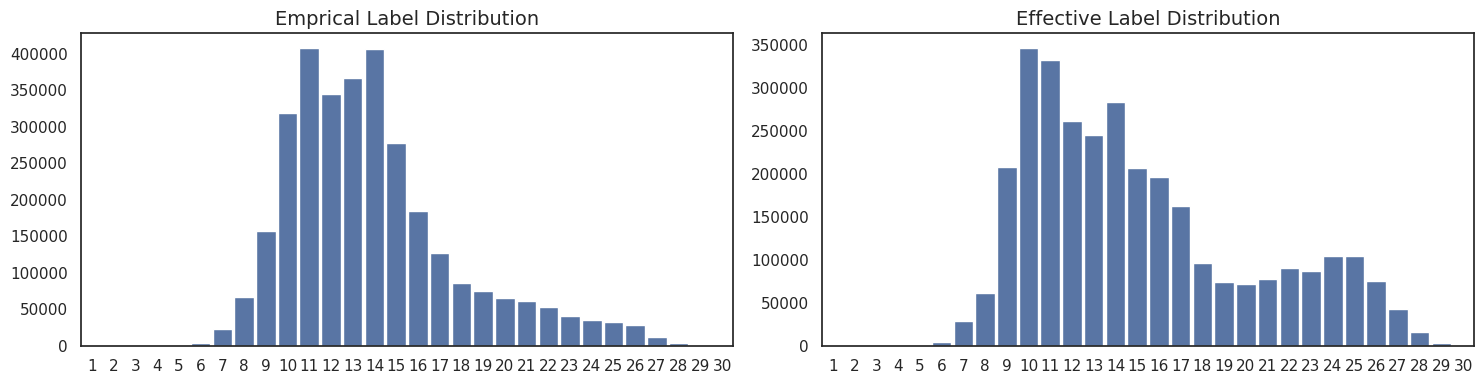

In [36]:
_ = utils.dual_emp_effective_hist_plot(vanilla_sample_nums, cost_sensitive_effective_sample_nums)

### LDS Visualization

### Perfromance 

In [23]:

RGB_test_cost_sensitive  = pd.read_csv('/data2/hkaman/Imbalance/EXPs/EXP_001_RGB_BHO/001_RGB_BHO_test.csv',  index_col=0) 
RGB_test_LDS_sqinv       = pd.read_csv('/data2/hkaman/Imbalance/EXPs/EXP_004_001_05_RGB_LDS/004_001_05_RGB_LDS_test.csv',  index_col=0) 
RGB_test_LDS_inv         = pd.read_csv('/data2/hkaman/Imbalance/EXPs/EXP_005_001_05_RGB_inv_LDS/005_001_05_RGB_inv_LDS_test.csv',  index_col=0) 
RGB_test_LDS_inv_20_6    = pd.read_csv('/data2/hkaman/Imbalance/EXPs/EXP_006_001_05_RGB_LDSinv_20_6/006_001_05_RGB_LDSinv_20_6_test.csv',  index_col=0) 

In [24]:
RGB_test_cost_vanilla_Output = Inference.eval_on_three_main_label_range_pred(RGB_test_cost_vanilla, th1 = 8, th2 = 24)
RGB_test_cost_sensitiv_Output = Inference.eval_on_three_main_label_range_pred(RGB_test_cost_sensitive, th1 = 8, th2 = 24)
RGB_test_LDS_sqinv_Output = Inference.eval_on_three_main_label_range_pred(RGB_test_LDS_sqinv, th1 = 8, th2 = 24)
RGB_test_LDS_inv_Output = Inference.eval_on_three_main_label_range_pred(RGB_test_LDS_inv, th1 = 8, th2 = 24)
RGB_test_LDS_inv_20_6_Output = Inference.eval_on_three_main_label_range_pred(RGB_test_LDS_inv_20_6, th1 = 8, th2 = 24)

95207 | 3010766 | 79435 
Test Dataset==> C1: MAE = 3.02, MAPE = 43.38 | C2: MAE = 1.61, MAPE = 12.43 | C3: MAE = 8.46, MAPE = 33.20
95801 | 2846898 | 242709 
Test Dataset==> C1: MAE = 1.53, MAPE = 22.63 | C2: MAE = 1.61, MAPE = 11.54 | C3: MAE = 4.62, MAPE = 18.06
95207 | 3010766 | 79435 
Test Dataset==> C1: MAE = 2.49, MAPE = 36.10 | C2: MAE = 1.57, MAPE = 11.67 | C3: MAE = 7.33, MAPE = 28.73
95207 | 3010766 | 79435 
Test Dataset==> C1: MAE = 2.29, MAPE = 33.12 | C2: MAE = 1.77, MAPE = 13.35 | C3: MAE = 4.00, MAPE = 15.73
95207 | 3010766 | 79435 
Test Dataset==> C1: MAE = 3.33, MAPE = 47.80 | C2: MAE = 1.87, MAPE = 13.91 | C3: MAE = 6.66, MAPE = 26.13


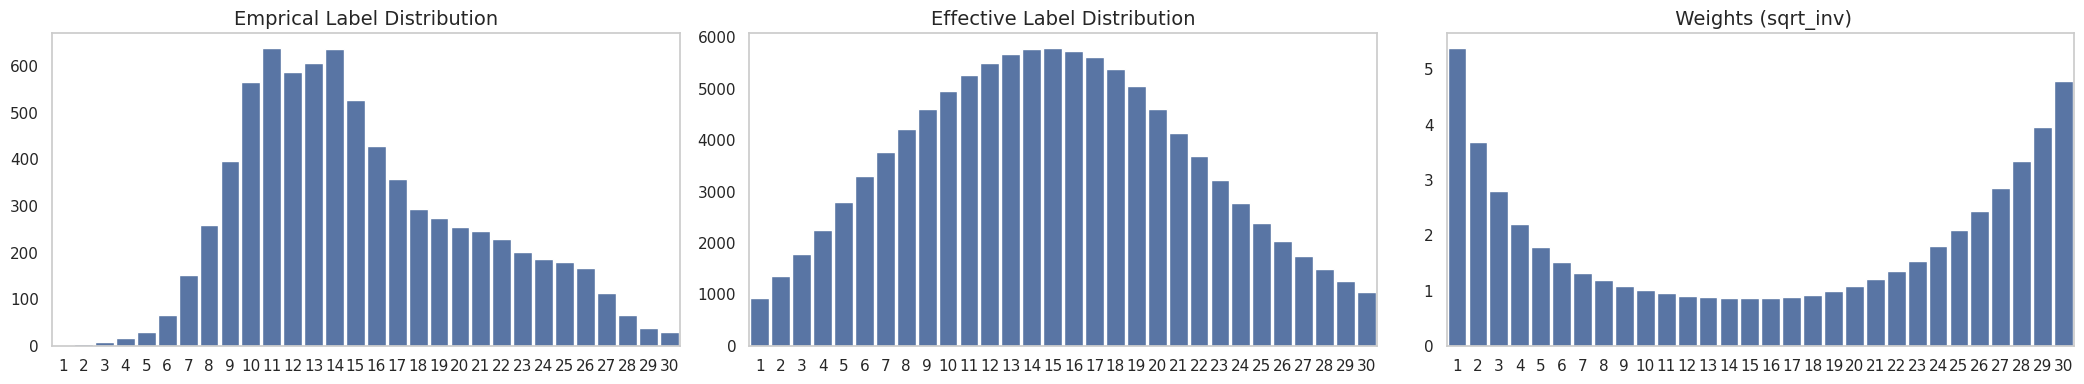

In [21]:
df = pd.read_csv('/data2/hkaman/Imbalance/EXPs/EXP_005_001_05_RGB_inv_LDS/coords/test.csv', index_col= 0)
weights, labels_, effective_value, emperical_values, avg_weights = RWSampler.check_lds_reweighting_(df, rw_method = 'sqrt_inv', lds_ks = 20, lds_sigma = 6).return_pixelwise_weight()
_ = utils.triple_emp_effective_weights_hist_plot(emperical_values, effective_value, avg_weights, method = 'sqrt_inv') 

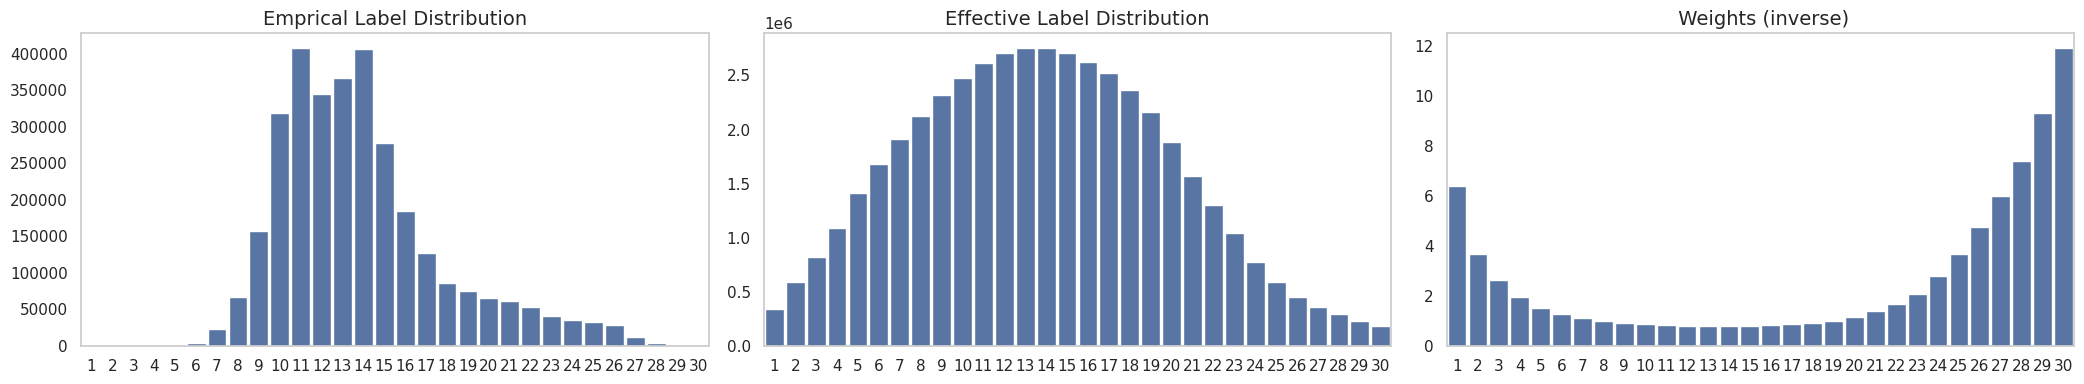

In [27]:
df = pd.read_csv('/data2/hkaman/Imbalance/EXPs/EXP_005_001_05_RGB_inv_LDS/coords/test.csv', index_col= 0)
weights, labels_, effective_value, emperical_values, avg_weights = RWSampler.check_lds_reweighting_(df, rw_method = 'inverse', lds_ks = 20, lds_sigma = 6).return_pixelwise_weight()
_ = utils.triple_emp_effective_weights_hist_plot(emperical_values, effective_value, avg_weights, method = 'inverse')